In [1]:
import math
import networkx as nx
import igraph as ig
import leidenalg as la
from ipysigma import Sigma, SigmaGrid
from pelote import filter_edges, triangular_strength, read_graphology_json, global_threshold_sparsification, multiscale_backbone, graph_to_edges_dataframe
from pelote.graph import union_of_maximum_spanning_trees
from heapq import nlargest
from fog.metrics.utils import intersection_size
from fog.metrics import jaccard_similarity
from ebbe import partitioned_items
from collections import Counter

Sigma.set_defaults(max_categorical_colors=25)

def wdist(g):
    return graph_to_edges_dataframe(g).weight.plot.hist()

## Leiden utils

In [2]:
def leiden_modularity(g: nx.Graph, weighted: bool = False):
    ig_g = ig.Graph.from_networkx(g)

    weights = None

    if weighted:
        weights = [w for _, _, w in g.edges(data="weight")]
    
    partition = la.find_partition(ig_g, la.ModularityVertexPartition, weights=weights)
    return {n: m for n, m in zip(g, partition._membership)}

In [3]:
def leiden_cpm(g: nx.Graph, resolution: float = 0.05):
    ig_g = ig.Graph.from_networkx(g)
    partition = la.find_partition(ig_g, la.CPMVertexPartition, resolution_parameter=resolution)
    return {n: m for n, m in zip(g, partition._membership)}

In [5]:
def hierarchical_leiden_modularity(g: nx.Graph):
    first_level = leiden_modularity(g)
    clusters = partitioned_items((v, k) for k, v in first_level.items())

    threshold = math.ceil(math.sqrt(g.order())) * 2

    result = {}
    
    for i, cluster in enumerate(clusters):
        if len(cluster) < threshold:
            for node in cluster:
                result[node] = str(i)

            continue
        
        subgraph = g.subgraph(cluster)
        second_level = leiden_modularity(subgraph)

        for j, sub_cluster in enumerate(partitioned_items((v, k) for k, v in second_level.items())):
            if j < 2:
                for node in sub_cluster:
                    result[node] = str(i) + '_' + str(j)
            else:
                for node in sub_cluster:
                    result[node] = str(i)

        # for node, j in second_level.items():
        #     result[node] = str(i) + '_' + str(j)

    return result

# Simmelian Backbones

## Undirected case

In [10]:
def undirected_simmelian_redudancies(graph: nx.Graph, m: int = 3):
    weights = triangular_strength(graph)

    NN = {}

    for node in graph:
        weighted_neighbors = sorted(
            [(neighbor, weights[(node, neighbor) if node < neighbor else (neighbor, node)]) for neighbor in graph.neighbors(node)],
            key=lambda t: t[1],
            reverse=True
        )
        best_neighbors = weighted_neighbors[:m]

        # NOTE: ties must be included
        if len(best_neighbors) < len(weighted_neighbors):
            best_weight = best_neighbors[-1][1]
            i = len(best_neighbors)

            while i < len(weighted_neighbors):
                n = weighted_neighbors[i]
                
                if n[1] == best_weight:
                    best_neighbors.append(n)
                else:
                    break

                i += 1
        
        NN[node] = [n[0] for n in best_neighbors]

    redundancies = {}

    for n1, n2 in graph.edges():
        if n1 > n2:
            (n1, n2) = (n2, n1)
        
        r = intersection_size(NN[n1], NN[n2])
        redundancies[(n1, n2)] = r

    return redundancies

In [11]:
def undirected_simmelian_projection(graph: nx.Graph, m: int = 3, t: int = 0, weights=None):
    weights = triangular_strength(graph) if weights is None else weights

    NN = {}
    h = nx.Graph()

    for node, attr in graph.nodes(data=True):
        h.add_node(node, **attr)
        
        weighted_neighbors = sorted(
            [(neighbor, weights[(node, neighbor) if node < neighbor else (neighbor, node)]) for neighbor in graph.neighbors(node)],
            key=lambda t: t[1],
            reverse=True
        )
        best_neighbors = weighted_neighbors[:m]

        # NOTE: ties must be included
        if len(best_neighbors) < len(weighted_neighbors):
            best_weight = best_neighbors[-1][1]
            i = len(best_neighbors)

            while i < len(weighted_neighbors):
                n = weighted_neighbors[i]
                
                if n[1] == best_weight:
                    best_neighbors.append(n)
                else:
                    break

                i += 1
        
        NN[node] = [n[0] for n in best_neighbors]

    nodes = list(graph)

    for i in range(len(nodes)):
        n1 = nodes[i]
        nn1 = NN[n1]
        
        for j in range(i + 1, len(nodes)):
            n2 = nodes[j]
            nn2 = NN[n2]

            r = intersection_size(nn1, nn2)

            if r > t:
                h.add_edge(n1, n2, weight=r)

    return h

In [12]:
def nth_order_undirected_simmelian_projection(graph, n: int, m: int = 3, t: int = 0):
    h = graph

    for _ in range(n):
        h = undirected_simmelian_projection(h, m=m, t=t)

    return h

In [13]:
g = nx.les_miserables_graph()

In [14]:
g_redundancies = undirected_simmelian_redudancies(g, m=3)

In [15]:
Sigma(
    g,
    node_size=g.degree,
    default_node_color="white",
    default_node_border_color="black",
    edge_color=g_redundancies,
    edge_color_gradient="Plasma",
    edge_size=g_redundancies,
    edge_size_range=(0.5, 5),
    edge_weight=g_redundancies
)

Sigma(nx.Graph with 77 nodes and 254 edges)

In [16]:
h = filter_edges(g, lambda u, v, _: g_redundancies[(u, v) if u < v else (v, u)] > 1)

In [17]:
Sigma(h)

Sigma(nx.Graph with 77 nodes and 151 edges)

In [43]:
p = nth_order_undirected_simmelian_projection(g, 2, m=3, t=0)

In [44]:
w = Sigma(
    p,
    node_size=p.degree,
    default_node_color="white",
    node_metrics=["louvain"],
    node_color="louvain",
    default_node_border_color="black",
    edge_color="weight",
    edge_color_gradient="Plasma",
    edge_size="weight",
    edge_size_range=(0.5, 5),
)
w

Sigma(nx.Graph with 77 nodes and 1,358 edges)

In [45]:
Sigma(g, node_size=g.degree, node_color=w.node_metrics["louvain"]["result"])

Sigma(nx.Graph with 77 nodes and 254 edges)

## Directed case

In [31]:
def inbound_simmelian_redudancies(graph: nx.Graph, m: int = 3, weights=None):
    weights = triangular_strength(graph) if weights is None else weights

    NN = {}

    for node in graph:
        weighted_neighbors = sorted(
            [(neighbor, weights[(node, neighbor) if node < neighbor else (neighbor, node)]) for neighbor in graph.predecessors(node)],
            key=lambda t: t[1],
            reverse=True
        )
        best_neighbors = weighted_neighbors[:m]

        # NOTE: ties must be included
        if len(best_neighbors) < len(weighted_neighbors):
            best_weight = best_neighbors[-1][1]
            i = len(best_neighbors)

            while i < len(weighted_neighbors):
                n = weighted_neighbors[i]
                
                if n[1] == best_weight:
                    best_neighbors.append(n)
                else:
                    break

                i += 1
        
        NN[node] = [n[0] for n in best_neighbors]

    redundancies = {}

    for n1, n2 in graph.edges():
        if n1 > n2:
            (n1, n2) = (n2, n1)
        
        r = intersection_size(NN[n1], NN[n2])
        redundancies[(n1, n2)] = r

    return redundancies

In [19]:
def inbound_simmelian_projection(graph: nx.Graph, m: int = 3, t: int = 0, weights=None):
    weights = triangular_strength(graph) if weights is None else weights

    NN = {}
    h = nx.Graph()

    for node, attr in graph.nodes(data=True):
        h.add_node(node, **attr)
        
        weighted_neighbors = sorted(
            [(neighbor, weights[(node, neighbor) if node < neighbor else (neighbor, node)]) for neighbor in graph.predecessors(node)],
            key=lambda t: t[1],
            reverse=True
        )
        best_neighbors = weighted_neighbors[:m]

        # NOTE: ties must be included
        if len(best_neighbors) < len(weighted_neighbors):
            best_weight = best_neighbors[-1][1]
            i = len(best_neighbors)

            while i < len(weighted_neighbors):
                n = weighted_neighbors[i]
                
                if n[1] == best_weight:
                    best_neighbors.append(n)
                else:
                    break

                i += 1
        
        NN[node] = [n[0] for n in best_neighbors]

    nodes = list(graph)

    for i in range(len(nodes)):
        n1 = nodes[i]
        nn1 = NN[n1]
        
        for j in range(i + 1, len(nodes)):
            n2 = nodes[j]
            nn2 = NN[n2]

            r = intersection_size(nn1, nn2)

            if r > t:
                h.add_edge(n1, n2, weight=r)

    return h

In [20]:
def nth_order_inbound_simmelian_projection(graph, n: int, m: int = 3, t: int = 0):
    h = inbound_simmelian_projection(graph, m=m, t=t, weights={((u, v) if u < v else (v, u)): 1 for u, v in graph.edges()})

    for _ in range(n - 1):
        h = undirected_simmelian_projection(h, m=m, t=t, weights={((u, v) if u < v else (v, u)): w for u, v, w in h.edges.data("weight")})

    return h

In [21]:
corpus = read_graphology_json("./polarisation.json")

In [32]:
redundancies = inbound_simmelian_redudancies(corpus, m=3)

In [23]:
Sigma(corpus.to_undirected(), edge_color=redundancies, edge_zindex=redundancies, edge_color_gradient=["rgba(0, 0, 0, 0.05)", "darkgray"], edge_weight=redundancies, default_node_border_color="black", default_node_color="white")

Sigma(nx.Graph with 420 nodes and 18,903 edges)

In [33]:
sparse_corpus = filter_edges(corpus, lambda u, v, _: redundancies[(u, v) if u < v else (v, u)] > 1)

In [36]:
# NOTE: should we apply cluster discretization or read as a map?
SigmaGrid(sparse_corpus, node_size=sparse_corpus.in_degree, default_node_border_color="white", node_size_range=(2, 10), views=[
    {"name": "Leiden", "node_metrics": ["louvain"], "node_color": "louvain"},
    {"name": "HLeiden", "node_color": hierarchical_leiden_modularity(sparse_corpus)},
    {"name": "CPM", "node_color": leiden_cpm(sparse_corpus, 0.05)},
    {"name": "Wheel", "node_color": "wheel_category"},
    {"name": "SubWheel", "node_color": "wheel_subcategory"}
], columns=3)

In [25]:
# NOTE: changement de phase à partir de 4?
projected_corpus = nth_order_inbound_simmelian_projection(corpus, 1)

In [26]:
Sigma(projected_corpus, node_size=corpus.in_degree, default_node_border_color="white", node_color="wheel_subcategory")

Sigma(nx.Graph with 420 nodes and 80,055 edges)

## Polarisation weights

<Axes: ylabel='Frequency'>

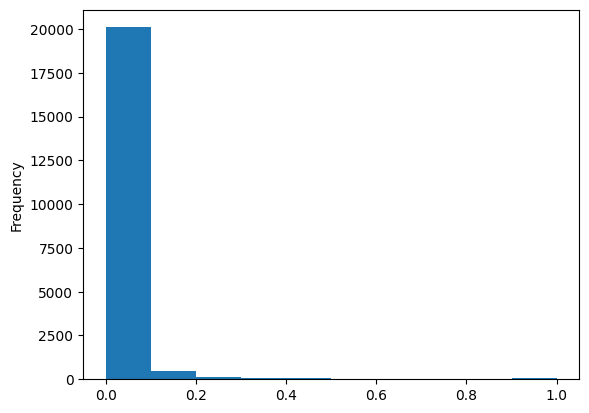

In [6]:
weighted_corpus = read_graphology_json('./polarisation.json')

totals = Counter()

for u in weighted_corpus:
    totals[u] = sum(w for _, _, w in weighted_corpus.out_edges(u, data="count"))

for u, v, a in weighted_corpus.edges.data():
    a["weight"] = a["count"] / totals[u]

wdist(weighted_corpus)

In [37]:
Sigma(
    global_threshold_sparsification(weighted_corpus, 0.00), # 0.05 works also
    node_size=weighted_corpus.in_degree(weight="weight"),
    node_color=leiden_modularity(weighted_corpus, weighted=True), node_metrics=["louvain"],
    edge_color="weight",
    edge_color_gradient=['#ddd', 'black'],
    edge_color_scale="sqrt",
    edge_zindex="weight",
    default_node_border_color="white"
)

Sigma(nx.DiGraph with 420 nodes and 20,935 edges)